In [1]:
# This notebook will run the model with a halved timestep
# this eliminates instability post-tilt when running back to steady state
# in this notebook, we will (always using the halved timestep):

# shrink the igneous domain
# run to steady state
# tilt
# run back to steady state
# record transient states
# double discharge from initial steady state
# run back to ss, recording transient states
# compare
# implement active tilting??

In [2]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)
q = x
double_q = 2*x

# set up references to topography
Hstar = 0.1
H = Hstar + np.zeros(len(x))
etab = -H
eta = etab + H

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:25] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[25:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:25] = 0.0001
k_sed = np.zeros(len(x))
k_sed[25:] = 0.001

In [4]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     q,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 850000, 
                     porosity = 0.55):
    
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.5 * (0.2 * dx * dx / (c*q[-1])) # time-step size

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        # calc grain attrition
        atr = 0.000004 * qs[1:]
        
        # calc change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0
        
        # track total erosion
        total_ero = bedrock_ero - sedimentation_rate
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
    return (eta, etab, S, efac, qs, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, 
            atr, sedimentation_rate, H, total_ero)

In [5]:
# up first, run our landscape to steady state

(eta_1, 
etab_1,
S_1,
efac_1,
qs_1,
ero_plucking_ig_1, 
ero_plucking_sed_1,
ero_ab_ig_1,
ero_ab_sed_1,
bedrock_ero_1, 
atr_1, 
sedimentation_rate_1, 
H_1, 
total_ero_1) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H,
                                etab,
                                eta,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed)

In [6]:
S_1

array([0.01099601, 0.00597576, 0.00430188, 0.0034644 , 0.00296139,
       0.00262555, 0.00238521, 0.00220452, 0.0020636 , 0.0019505 ,
       0.00185764, 0.00177994, 0.00171391, 0.00165704, 0.00160751,
       0.00156393, 0.00152526, 0.00149068, 0.00145954, 0.00143133,
       0.00140563, 0.0013821 , 0.00136045, 0.00134045, 0.00093354,
       0.00089213, 0.0008558 , 0.00082209, 0.00079071, 0.00076143,
       0.00073405, 0.0007084 , 0.00068431, 0.00066165, 0.00064029,
       0.00062013, 0.00060107, 0.00058302, 0.0005659 , 0.00054965,
       0.0005342 , 0.00051949, 0.00050547, 0.0004921 , 0.00047934,
       0.00046713, 0.00045545, 0.00044426, 0.00043354, 0.00042325,
       0.00041337, 0.00040388, 0.00039475, 0.00038597, 0.00037751,
       0.00036936, 0.0003615 , 0.00035391, 0.00034659, 0.00033952,
       0.00033269, 0.00032608, 0.00031968, 0.00031349, 0.0003075 ,
       0.00030169, 0.00029606, 0.0002906 , 0.0002853 , 0.00028016,
       0.00027516, 0.00027031, 0.0002656 , 0.00026102, 0.00025

In [7]:
# the above cell has just created outputs that have run to steady state 
# (can check this by looking at `total_ero` and seeing that it is the same as the baselevel lowering rate)
# now tilt the topography and bedrock and check out what happens after 1 timestep

In [12]:
upstream_tilt_factor = np.linspace(270, 1, 100)

eta_tilt = eta_1 + upstream_tilt_factor
etab_tilt = etab_1 + upstream_tilt_factor

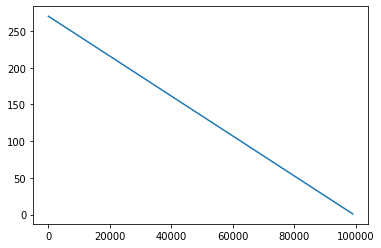

In [19]:
# plt.plot(x, eta_1)
# plt.plot(x, eta_tilt)
plt.plot(x, upstream_tilt_factor)

In [13]:
# now use the tilted bedrock and topography as the inputs to another model run
# use the sediment thickness output at steady state from the previous run as the input for `H`
# (this is because we want to tilt the landscape up, but we do not want to overthicken H)

In [14]:
# # now run for one time step after tectonically tilting the land surface

(eta_2, 
etab_2,
S_2,
efac_2,
qs_2,
ero_plucking_ig_2, 
ero_plucking_sed_2,
ero_ab_ig_2,
ero_ab_sed_2,
bedrock_ero_2, 
atr_2, 
sedimentation_rate_2, 
H_2, 
total_ero_2) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 1)

In [15]:
S_2

array([0.01371319, 0.00869294, 0.00701905, 0.00618157, 0.00567856,
       0.00534272, 0.00510238, 0.0049217 , 0.00478077, 0.00466768,
       0.00457481, 0.00449711, 0.00443108, 0.00437421, 0.00432468,
       0.0042811 , 0.00424243, 0.00420785, 0.00417671, 0.0041485 ,
       0.0041228 , 0.00409927, 0.00407762, 0.00405763, 0.00365072,
       0.0036093 , 0.00357298, 0.00353926, 0.00350788, 0.0034786 ,
       0.00345122, 0.00342557, 0.00340148, 0.00337882, 0.00335746,
       0.0033373 , 0.00331824, 0.00330019, 0.00328307, 0.00326682,
       0.00325137, 0.00323666, 0.00322265, 0.00320928, 0.00319651,
       0.0031843 , 0.00317262, 0.00316143, 0.00315071, 0.00314042,
       0.00313054, 0.00312105, 0.00311192, 0.00310314, 0.00309468,
       0.00308653, 0.00307867, 0.00307109, 0.00306376, 0.00305669,
       0.00304986, 0.00304325, 0.00303685, 0.00303066, 0.00302467,
       0.00301886, 0.00301323, 0.00300777, 0.00300247, 0.00299733,
       0.00299234, 0.00298749, 0.00298277, 0.00297819, 0.00297

In [11]:
# making copies of all the outputs from Run 2 because... idk, something weird is going on
# and these outputs seem to be affected when I run the model a third time (to steady state)

eta_2_copy = eta_2.copy()
etab_2_copy = etab_2.copy()
S_2_copy = S_2.copy()
efac_2_copy = efac_2.copy()
qs_2_copy = qs_2.copy()
ero_plucking_ig_2_copy = ero_plucking_ig_2.copy()
ero_plucking_sed_2_copy = ero_plucking_sed_2.copy()
ero_ab_ig_2_copy = ero_ab_ig_2.copy()
ero_ab_sed_2_copy = ero_ab_sed_2.copy()
bedrock_ero_2_copy = bedrock_ero_2.copy()
atr_2_copy = atr_2.copy()
sedimentation_rate_2_copy = sedimentation_rate_2.copy()
H_2_copy = H_2.copy()
total_ero_2_copy = total_ero_2.copy()

In [12]:
# finally, run our tilted landscape back to steady state

(eta_3, 
etab_3,
S_3,
efac_3,
qs_3,
ero_plucking_ig_3, 
ero_plucking_sed_3,
ero_ab_ig_3,
ero_ab_sed_3,
bedrock_ero_3, 
atr_3, 
sedimentation_rate_3, 
H_3, 
total_ero_3) = two_lith_one_sed(x,
                                dx,
                                q,
                                Hstar,
                                H_1,
                                etab_tilt,
                                eta_tilt,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed)

In [13]:
total_ero_3

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   ])

In [14]:
# now we want to preturb climate after initially reaching steady state
# we do this by doubling discharge and using the outputs from our first steady state run as the inputs to this run

In [15]:
# perturb climate on our ss, untilted landscape

(eta_4, 
etab_4,
S_4,
efac_4,
qs_4,
ero_plucking_ig_4, 
ero_plucking_sed_4,
ero_ab_ig_4,
ero_ab_sed_4,
bedrock_ero_4, 
atr_4, 
sedimentation_rate_4, 
H_4, 
total_ero_4) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed,
                                num_steps = 1)

In [16]:
# making copies of all the outputs from Run 4 because... idk, something weird is going on
# and these outputs seem to be affected when I run the model a third time (to steady state)

eta_4_copy = eta_4.copy()
etab_4_copy = etab_4.copy()
S_4_copy = S_4.copy()
efac_4_copy = efac_4.copy()
qs_4_copy = qs_4.copy()
ero_plucking_ig_4_copy = ero_plucking_ig_4.copy()
ero_plucking_sed_4_copy = ero_plucking_sed_4.copy()
ero_ab_ig_4_copy = ero_ab_ig_4.copy()
ero_ab_sed_4_copy = ero_ab_sed_4.copy()
bedrock_ero_4_copy = bedrock_ero_4.copy()
atr_4_copy = atr_4.copy()
sedimentation_rate_4_copy = sedimentation_rate_4.copy()
H_4_copy = H_4.copy()
total_ero_4_copy = total_ero_4.copy()

In [17]:
# and now run our climate-perturbed landscape back to steady state

(eta_5, 
etab_5,
S_5,
efac_5,
qs_5,
ero_plucking_ig_5, 
ero_plucking_sed_5,
ero_ab_ig_5,
ero_ab_sed_5,
bedrock_ero_5, 
atr_5, 
sedimentation_rate_5, 
H_5, 
total_ero_5) = two_lith_one_sed(x,
                                dx,
                                double_q,
                                Hstar,
                                H_1,
                                etab_1,
                                eta_1,
                                beta_ig,
                                beta_sed,
                                k_ig,
                                k_sed)

In [18]:
total_ero_5

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   ])

In [19]:
# our perturbed landscape is now back at steady state
# so now we just want to look at each of our metrics in comparison and see how things are evolving

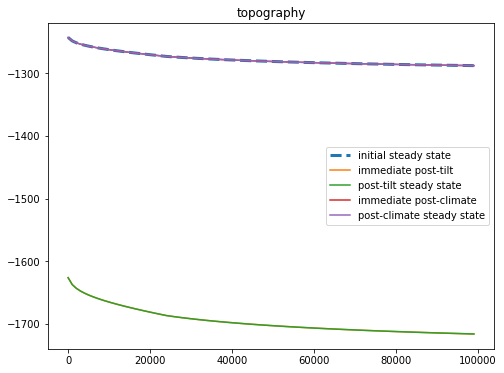

In [20]:
# check out topography
plt.figure(figsize = (8, 6))

plt.plot(x, eta_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, eta_2, label = 'immediate post-tilt')
plt.plot(x, eta_3, label = 'post-tilt steady state')
plt.plot(x, eta_4, label = 'immediate post-climate')
plt.plot(x, eta_5, label = 'post-climate steady state')
plt.title('topography')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/topographic elevation.png')

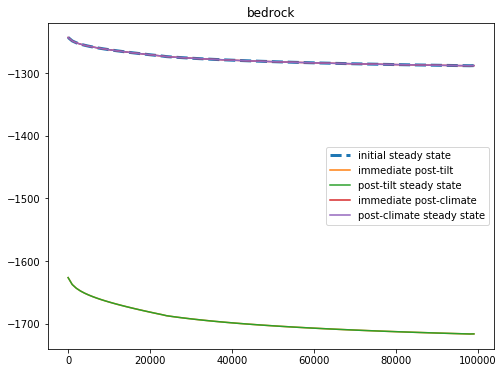

In [21]:
# check out bedrock
plt.figure(figsize = (8, 6))

plt.plot(x, etab_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, etab_2, label = 'immediate post-tilt')
plt.plot(x, etab_3, label = 'post-tilt steady state')
plt.plot(x, etab_4, label = 'immediate post-climate')
plt.plot(x, etab_5, label = 'post-climate steady state')
plt.title('bedrock')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/bedrock elevation.png')

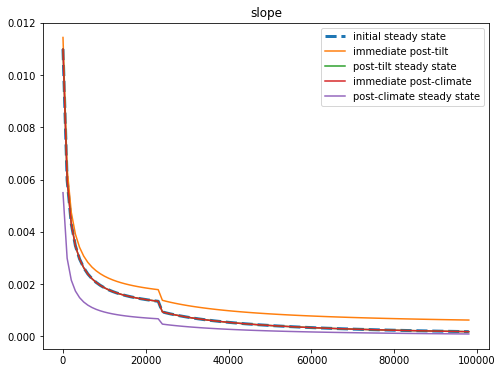

In [22]:
# check out slopes
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], S_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], S_2, label = 'immediate post-tilt')
plt.plot(x[:-1], S_3, label = 'post-tilt steady state')
plt.plot(x[:-1], S_4, label = 'immediate post-climate')
plt.plot(x[:-1], S_5, label = 'post-climate steady state')
plt.title('slope')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/slopes.png')

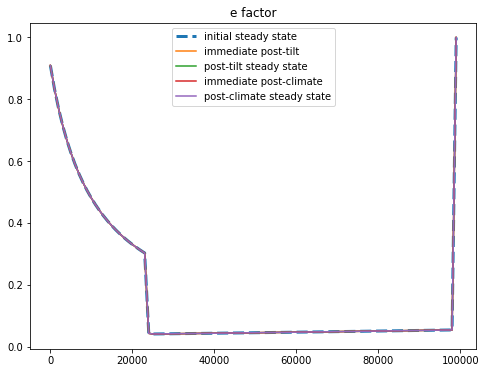

In [23]:
# check out efactor
plt.figure(figsize = (8, 6))

plt.plot(x, efac_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, efac_2, label = 'immediate post-tilt')
plt.plot(x, efac_3, label = 'post-tilt steady state')
plt.plot(x, efac_4, label = 'immediate post-climate')
plt.plot(x, efac_5, label = 'post-climate steady state')
plt.title('e factor')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/e factor.png')

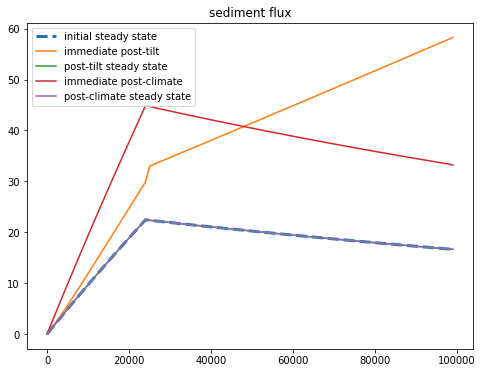

In [24]:
# check out qs
plt.figure(figsize = (8, 6))

plt.plot(x, qs_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, qs_2, label = 'immediate post-tilt')
plt.plot(x, qs_3, label = 'post-tilt steady state')
plt.plot(x, qs_4, label = 'immediate post-climate')
plt.plot(x, qs_5, label = 'post-climate steady state')
plt.title('sediment flux')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/sediment flux.png')

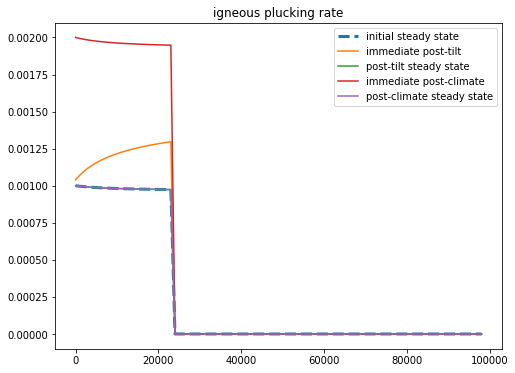

In [25]:
# check out igneous plucking
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_plucking_ig_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], ero_plucking_ig_2, label = 'immediate post-tilt')
plt.plot(x[:-1], ero_plucking_ig_3, label = 'post-tilt steady state')
plt.plot(x[:-1], ero_plucking_ig_4, label = 'immediate post-climate')
plt.plot(x[:-1], ero_plucking_ig_5, label = 'post-climate steady state')
plt.title('igneous plucking rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/igneous plucking rate.png')

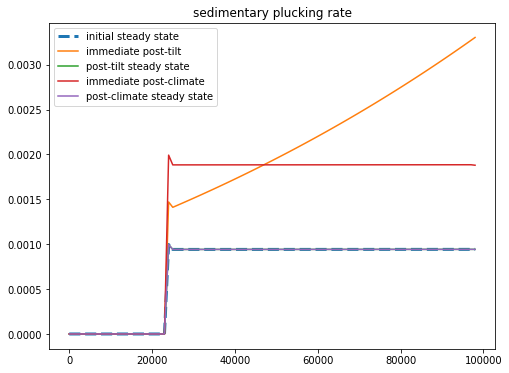

In [26]:
# check out sedimentary plucking
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_plucking_sed_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], ero_plucking_sed_2, label = 'immediate post-tilt')
plt.plot(x[:-1], ero_plucking_sed_3, label = 'post-tilt steady state')
plt.plot(x[:-1], ero_plucking_sed_4, label = 'immediate post-climate')
plt.plot(x[:-1], ero_plucking_sed_5, label = 'post-climate steady state')
plt.title('sedimentary plucking rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/sedimentary plucking rate.png')

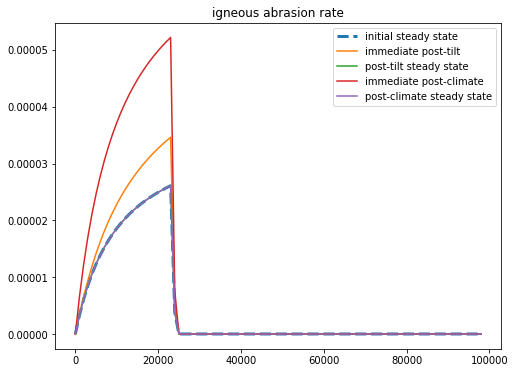

In [27]:
# check out igneous abrasion
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_ab_ig_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], ero_ab_ig_2, label = 'immediate post-tilt')
plt.plot(x[:-1], ero_ab_ig_3, label = 'post-tilt steady state')
plt.plot(x[:-1], ero_ab_ig_4, label = 'immediate post-climate')
plt.plot(x[:-1], ero_ab_ig_5, label = 'post-climate steady state')
plt.title('igneous abrasion rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/igneous abrasion rate.png')

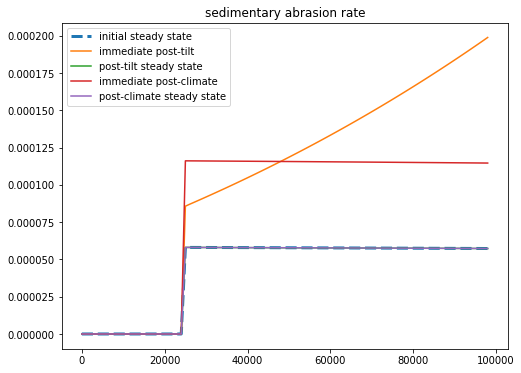

In [28]:
# check out sedimentary abrasion
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], ero_ab_sed_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], ero_ab_sed_2, label = 'immediate post-tilt')
plt.plot(x[:-1], ero_ab_sed_3, label = 'post-tilt steady state')
plt.plot(x[:-1], ero_ab_sed_4, label = 'immediate post-climate')
plt.plot(x[:-1], ero_ab_sed_5, label = 'post-climate steady state')
plt.title('sedimentary abrasion rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/sedimentary abrasion rate.png')

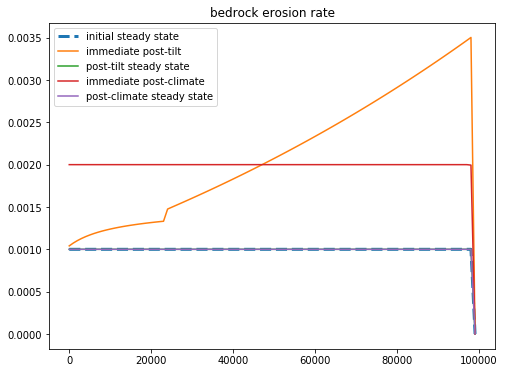

In [29]:
# check out bedrock erosion
plt.figure(figsize = (8, 6))

plt.plot(x, bedrock_ero_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, bedrock_ero_2, label = 'immediate post-tilt')
plt.plot(x, bedrock_ero_3, label = 'post-tilt steady state')
plt.plot(x, bedrock_ero_4, label = 'immediate post-climate')
plt.plot(x, bedrock_ero_5, label = 'post-climate steady state')
plt.title('bedrock erosion rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/bedrock erosion rate.png')

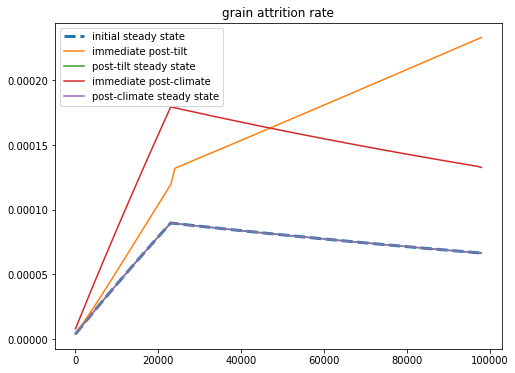

In [30]:
# check out attrition rate
plt.figure(figsize = (8, 6))

plt.plot(x[:-1], atr_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x[:-1], atr_2, label = 'immediate post-tilt')
plt.plot(x[:-1], atr_3, label = 'post-tilt steady state')
plt.plot(x[:-1], atr_4, label = 'immediate post-climate')
plt.plot(x[:-1], atr_5, label = 'post-climate steady state')
plt.title('grain attrition rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/grain attrition rate.png')

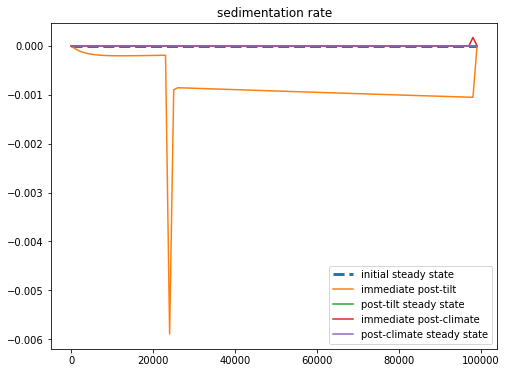

In [31]:
# check out sedimentation rate
plt.figure(figsize = (8, 6))

plt.plot(x, sedimentation_rate_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, sedimentation_rate_2, label = 'immediate post-tilt')
plt.plot(x, sedimentation_rate_3, label = 'post-tilt steady state')
plt.plot(x, sedimentation_rate_4, label = 'immediate post-climate')
plt.plot(x, sedimentation_rate_5, label = 'post-climate steady state')
plt.title('sedimentation rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/sedimentation rate.png')

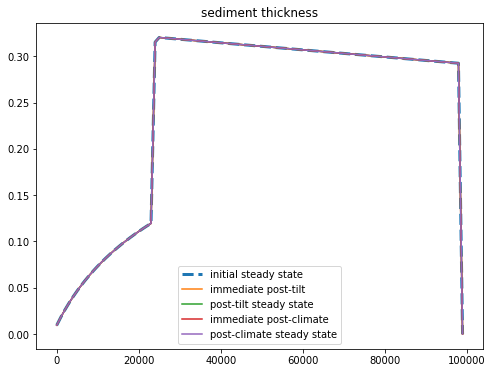

In [32]:
# check out sediment thickness
plt.figure(figsize = (8, 6))

plt.plot(x, H_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, H_2, label = 'immediate post-tilt')
plt.plot(x, H_3, label = 'post-tilt steady state')
plt.plot(x, H_4, label = 'immediate post-climate')
plt.plot(x, H_5, label = 'post-climate steady state')
plt.title('sediment thickness')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/sediment thickness.png')

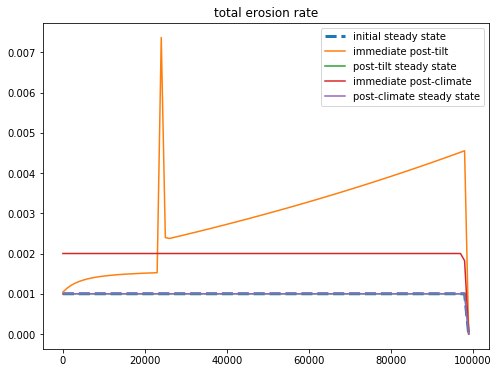

In [33]:
# check out total erosion rate
plt.figure(figsize = (8, 6))

plt.plot(x, total_ero_1, label = 'initial steady state', linestyle = '--', linewidth = 3)
plt.plot(x, total_ero_2, label = 'immediate post-tilt')
plt.plot(x, total_ero_3, label = 'post-tilt steady state')
plt.plot(x, total_ero_4, label = 'immediate post-climate')
plt.plot(x, total_ero_5, label = 'post-climate steady state')
plt.title('total erosion rate')
plt.legend()

plt.savefig('/Users/vanessa/Desktop/FA 2021/outputs for 9_22_21 meeting/total erosion rate.png')